# (c) LSTM + ADAM + 50d

In [ ]:
import numpy as np
from emo_utils import *

# glove 데이터 얻어오는 부분
glove_50d_path = "glove_file/glove.6b.50d.txt"
# glove_100d_path = "glove_file/glove.6b.100d.txt"

words_to_index_50d, index_to_words_50d, word_to_vec_map_50d = read_glove_vecs(glove_50d_path)
# words_to_index_100d, index_to_words_100d, word_to_vec_map_100d = read_glove_vecs(glove_100d_path)

# test data와 train data 얻어오는 부분
test_phase, test_emoji = read_csv('test_emoji.csv')
train_phase, train_emoji = read_csv('train_emoji.csv')

# emoji를 one-hot encoding하기
train_true = np.eye(5)[train_emoji]  # 5*132
test_true = np.eye(5)[test_emoji]   # 5*52

In [42]:
def padding_and_embedding(sentences, word_to_vec_map, max_len=10, embedding_dim=50):
    batch = len(sentences)
    embedded_sentences = np.zeros((batch,max_len,embedding_dim))
    padding_mask = np.zeros((batch, max_len))
    actual_lengths = []
    for i, sentence in enumerate(sentences):
        words = sentence.lower().split()
        actual_lengths.append(len(words))
        for j, word in enumerate(words[:max_len]):
            if word in word_to_vec_map:
                embedded_sentences[i,j] = word_to_vec_map[word]
                padding_mask[i, j] = 1
    return embedded_sentences, padding_mask, actual_lengths

train_embeddings, train_padding_mask, train_lengths = padding_and_embedding(train_phase, word_to_vec_map_50d)
test_embeddings, test_padding_mask,  test_lengths = padding_and_embedding(test_phase, word_to_vec_map_50d)

In [ ]:
class lstm_cell:
    def __init__(self, input_dim, hidden_dim):
        # 통합된 가중치와 편향
        self.Wx = np.random.randn(input_dim, 4 * hidden_dim) * np.sqrt(2 / input_dim)
        self.Wh = np.random.randn(hidden_dim, 4 * hidden_dim) * np.sqrt(2 / hidden_dim)
        self.b = np.zeros((1, 4 * hidden_dim))

        # 그래디언트 초기화
        self.dWx = np.zeros_like(self.Wx)
        self.dWh = np.zeros_like(self.Wh)
        self.db = np.zeros_like(self.b)
    
    def sigmoid(self,z):
        return 1 / (1 + np.exp(-z))

    def forward(self, x):
        batch_size, time_steps, input_dim = x.shape
        hidden_dim = self.Wh.shape[1] // 4

        self.hidden_states = np.zeros((batch_size, time_steps, hidden_dim))
        self.cell_states = np.zeros((batch_size, time_steps, hidden_dim))
        self.f_t = np.zeros((batch_size, time_steps, hidden_dim))  # Forget gate
        self.i_t = np.zeros((batch_size, time_steps, hidden_dim))  # Input gate
        self.g_t = np.zeros((batch_size, time_steps, hidden_dim))  # Cell gate
        self.o_t = np.zeros((batch_size, time_steps, hidden_dim)) # Output gate

        self.x = x
        self.h_prev = np.zeros((batch_size, hidden_dim))
        self.c_prev = np.zeros((batch_size, hidden_dim))

        for t in range(time_steps):
            self.x_t = x[:, t, :]

            # 아핀 변환: 모든 게이트 연산을 한 번에 수행
            z = np.dot(self.x_t, self.Wx) + np.dot(self.h_prev, self.Wh) + self.b

            # 게이트 분리(backward에서 사용하기 위해서 저장)
            self.f_t[:, t, :] = self.sigmoid(z[:, :hidden_dim])  # Forget gate
            self.i_t[:, t, :] = self.sigmoid(z[:, hidden_dim:2*hidden_dim])  # Input gate
            self.g_t[:, t, :] = np.tanh(z[:, 2*hidden_dim:3*hidden_dim])  # Cell gate
            self.o_t[:, t, :] = self.sigmoid(z[:, 3*hidden_dim:])  # Output gate

            # 셀 상태 및 출력 상태 업데이트
            self.c_next = self.f_t[:, t, :] * self.c_prev + self.i_t[:, t, :] * self.g_t[:, t, :]
            self.h_next = self.o_t[:, t, :] * np.tanh(self.c_next)

            # 상태 저장
            self.hidden_states[:, t, :] = self.h_next
            self.cell_states[:, t, :] = self.c_next

            # 다음 단계 준비
            self.h_prev = self.h_next
            self.c_prev = self.c_next

        return self.hidden_states
    
    # 2층 lstm의 backward 경우에는 2차원의 입력을 받음
    # 출력값은 3차원이 되어야 함(timestep항 포함)
    def backward_lstm2(self, dh_last):
        batch_size, hidden_dim = dh_last.shape
        time_steps = self.hidden_states.shape[1]
        input_dim = self.Wx.shape[0]

        dx = np.zeros((batch_size, time_steps, input_dim))
        dh_next = np.zeros((batch_size, hidden_dim))
        dc_next = np.zeros((batch_size, hidden_dim))

        for t in reversed(range(time_steps)):
            # 현재 timestep의 그래디언트
            dh = dh_last if t == time_steps - 1 else dh_next
            dc = dc_next

            # Output 게이트 기울기
            tanh_c = np.tanh(self.cell_states[:, t, :])
            do = dh * tanh_c
            do *= self.o_t[:, t, :] * (1 - self.o_t[:, t, :])

            # Cell state 기울기
            dc += dh * self.o_t[:, t, :] * (1 - tanh_c**2)
            
            # Forget 게이트 기울기
            df = dc * (self.cell_states[:, t - 1, :] if t > 0 else 0)
            df *= self.f_t[:, t, :] * (1 - self.f_t[:, t, :])

            # Input 게이트 기울기
            di = dc * self.g_t[:, t, :]
            di *= self.i_t[:, t, :] * (1 - self.i_t[:, t, :])

            # New Cell 기울기
            dg = dc * self.i_t[:, t, :]
            dg *= (1 - self.g_t[:, t, :]**2)

            # dA 계산 (수직으로 스택)
            dA = np.hstack((df, di, dg, do))

            # 가중치 기울기 업데이트
            self.dWx += np.dot(self.x[:, t, :].T, dA)
            if t > 0:
                self.dWh += np.dot(self.hidden_states[:, t - 1, :].T, dA)
            else:
                self.dWh += np.zeros_like(self.dWh)
            self.db += np.sum(dA, axis=0, keepdims=True)

            # 입력 기울기
            dx[:, t, :] = np.dot(dA, self.Wx.T)

            # 다음 timestep에 전달할 기울기
            dh_next = np.dot(dA, self.Wh.T)
            dc_next = self.f_t[:, t, :] * dc

        return dx
    
    # 1층 lstm의 backward 경우에는 3차원의 입력을 받음
    def backward_lstm1(self, dh_last):
        batch_size,time_steps ,hidden_dim = dh_last.shape
        input_dim = self.Wx.shape[0]

        dx = np.zeros((batch_size, time_steps, input_dim))
        dh_next = np.zeros((batch_size, hidden_dim))
        dc_next = np.zeros((batch_size, hidden_dim))

        for t in reversed(range(time_steps)):
            # 현재 timestep의 그래디언트
            dh = dh_last[:,t,:] if t == time_steps - 1 else dh_next
            dc = dc_next

            # Output 게이트 기울기
            tanh_c = np.tanh(self.cell_states[:, t, :])
            do = dh * tanh_c
            do *= self.o_t[:, t, :] * (1 - self.o_t[:, t, :])

            # Cell state 기울기
            dc += dh * self.o_t[:, t, :] * (1 - tanh_c**2)

            # Forget 게이트 기울기
            df = dc * (self.cell_states[:, t - 1, :] if t > 0 else 0)
            df *= self.f_t[:, t, :] * (1 - self.f_t[:, t, :])

            # Input 게이트 기울기
            di = dc * self.g_t[:, t, :]
            di *= self.i_t[:, t, :] * (1 - self.i_t[:, t, :])

            # New Cell 기울기
            dg = dc * self.i_t[:, t, :]
            dg *= (1 - self.g_t[:, t, :]**2)

            # dA 계산
            dA = np.hstack((df, di, dg, do))

            # 가중치 기울기 업데이트
            self.dWx += np.dot(self.x[:, t, :].T, dA)
            if t > 0:
                self.dWh += np.dot(self.hidden_states[:, t - 1, :].T, dA)
            else:
                self.dWh += np.zeros_like(self.dWh) 
            self.db += np.sum(dA, axis=0, keepdims=True)

            # 입력 기울기
            dx[:, t, :] = np.dot(dA, self.Wx.T)

            # 다음 timestep에 전달할 기울기
            dh_next = np.dot(dA, self.Wh.T)
            dc_next = self.f_t[:, t, :] * dc

        return dx

In [ ]:
class linear:
    def __init__(self, learning_rate, input_size, output_size=5):
        self.learning_rate = learning_rate
        self.weight = np.random.randn(input_size, output_size) * np.sqrt(1 / (input_size))
        self.bias = np.random.randn(1, output_size)* np.sqrt(1 / (output_size)) 

        self.dweight = np.zeros_like(self.weight)
        self.dbias = np.zeros_like(self.bias)

    def forward(self, input):   
        self.input = input  # Backpropagation을 위해 저장
        return np.dot(input, self.weight) + self.bias

    def backward(self, output_gradient):
        self.dweight = np.dot(self.input.T, output_gradient)
        self.dbias = np.sum(output_gradient, axis=0, keepdims=True)
        input_gradient = np.dot(output_gradient, self.weight.T)  # (batch_size, input_size)
        return input_gradient

In [45]:
def clip_gradient(grad, max_grad_norm=1.0):
    grad_norm = np.linalg.norm(grad)
    if grad_norm > max_grad_norm:
        grad = grad * (max_grad_norm / grad_norm)
    return grad

class Dropout:
    def __init__(self, keep_prob):
        self.keep_prob = keep_prob

    def forward(self, x, is_training=True):
        if not is_training:
            return x
        self.mask = (np.random.rand(*x.shape) < self.keep_prob) / self.keep_prob
        return x * self.mask
    
    def backward(self, grad_output):
        grad_output = clip_gradient(grad_output)
        return grad_output * self.mask

In [ ]:
class LstmNetwork:
    def __init__(self, input_dim, hidden_dim, output_dim, keep_prob, learning_rate):
        # LSTM Layers
        self.lstm1 = lstm_cell(input_dim=input_dim, hidden_dim=hidden_dim)
        self.dropout1 = Dropout(keep_prob=keep_prob)
        self.lstm2 = lstm_cell(input_dim=hidden_dim, hidden_dim=hidden_dim)
        self.dropout2 = Dropout(keep_prob=keep_prob)
        self.linear = linear(learning_rate=learning_rate, input_size=hidden_dim, output_size=output_dim)
    
    def forward(self, x, is_training=True):
        self.inputs = [None] * 5
        self.inputs[0] = self.lstm1.forward(x)  # Output: (batch_size, time_steps, hidden_dim)
        self.inputs[1] = self.dropout1.forward(self.inputs[0], is_training)  # Shape: (batch_size, time_steps, hidden_dim)
        self.inputs[2] = self.lstm2.forward(self.inputs[1])[:, -1, :]  # Shape: (batch_size, hidden_dim)
        self.inputs[3] = self.dropout2.forward(self.inputs[2], is_training)  # Shape: (batch_size, hidden_dim)
        self.inputs[4] = self.linear.forward(self.inputs[3])  # Shape: (batch_size, output_dim)
        return self.inputs[4]
    
    def backward(self, output_gradient):
        grad = self.linear.backward(output_gradient)  # Shape: (batch_size, hidden_dim)
        grad = self.dropout2.backward(grad)  # Shape: (batch_size, hidden_dim)
        grad = self.lstm2.backward_lstm2(grad)  # Shape: (batch_size, time_steps, hidden_dim)
        grad = self.dropout1.backward(grad)  # Shape: (batch_size, time_steps, hidden_dim)
        dx = self.lstm1.backward_lstm1(grad)  # Shape: (batch_size, time_steps, input_dim)
        return dx


In [47]:
class SGD:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def update(self, param, grad):
        return param - self.learning_rate * grad

# ADAM optimizer 정의

In [ ]:
class Adam:
    def __init__(self, learning_rate, beta1=0.9, beta2=0.999):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.first_moment = {}
        self.second_moment = {}

    def initialize_params(self, params):
        for key, value in params.items():
            self.first_moment[key] = np.zeros_like(value)
            self.second_moment[key] = np.zeros_like(value)

    def update(self, params, grads):
        updated_params = {}

        for t, (key, grad) in enumerate(grads.items(), start=1):
            # momentum 계산
            self.first_moment[key] = self.beta1 * self.first_moment[key] + (1 - self.beta1) * grad
            self.second_moment[key] = self.beta2 * self.second_moment[key] + (1 - self.beta2) * (grad**2)

            # Bias correction
            first_unbias = self.first_moment[key] / (1 - self.beta1**t)
            second_unbias = self.second_moment[key] / (1 - self.beta2**t)

            updated_params[key] = params[key] - self.learning_rate * first_unbias / (np.sqrt(second_unbias) + 1e-7)

        return updated_params


In [ ]:
def SoftMax(output):  # batch, 5
    output -= np.max(output, axis=1, keepdims=True)
    # output = np.clip(output, -1, 1)
    exp_output = np.exp(output)
    softmax_values = exp_output / np.sum(exp_output, axis=1, keepdims=True)
    return softmax_values

class CE_Loss():
    def forward(self, y_pred, y_true):  # (batch_size, 5)
        y_pred = np.clip(y_pred, 1e-15, 1-1e-15)  # log값이 0이 되어 발산하는 거 방지
        loss = -np.sum(y_true*np.log(y_pred), axis=1)
        return np.mean(loss)  # 그냥 loss 출력해도 되지만 epoch당 loss를 알아보기 위해서
    
    def backward(self, y_pred, y_true):
        return y_pred-y_true

In [ ]:
def LSTM_train_adam(model, x_train, y_train, batch_size, train_loss, adam_optimizer):
    num_iters = x_train.shape[0] // batch_size
    tmp_loss = []

    # Adam 초기화에서 사용할 가중치와 gradient 딕셔너리
    params = {
        "lstm1_Wx": model.lstm1.Wx,
        "lstm1_Wh": model.lstm1.Wh,
        "lstm1_b": model.lstm1.b,
        "lstm2_Wx": model.lstm2.Wx,
        "lstm2_Wh": model.lstm2.Wh,
        "lstm2_b": model.lstm2.b,
        "linear_weight": model.linear.weight,
        "linear_bias": model.linear.bias,
    }

    grads = {
        "lstm1_Wx": model.lstm1.dWx,
        "lstm1_Wh": model.lstm1.dWh,
        "lstm1_b": model.lstm1.db,
        "lstm2_Wx": model.lstm2.dWx,
        "lstm2_Wh": model.lstm2.dWh,
        "lstm2_b": model.lstm2.db,
        "linear_weight": model.linear.dweight,
        "linear_bias": model.linear.dbias,
    }

    # Adam 초기화
    adam_optimizer.initialize_params(params)

    for i in range(num_iters):
        x_batch = x_train[i * batch_size:(i + 1) * batch_size, :, :]
        y_batch = y_train[i * batch_size:(i + 1) * batch_size, :]

        output = model.forward(x_batch, is_training=True)

        y_pred = SoftMax(output)

        loss_fn = CE_Loss()
        loss = loss_fn.forward(y_pred, y_batch)
        tmp_loss.append(loss)

        output_gradient = loss_fn.backward(y_pred, y_batch)
        model.backward(output_gradient)

        params = adam_optimizer.update(params, grads)

        model.lstm1.Wx, model.lstm1.Wh, model.lstm1.b = params["lstm1_Wx"], params["lstm1_Wh"], params["lstm1_b"]
        model.lstm2.Wx, model.lstm2.Wh, model.lstm2.b = params["lstm2_Wx"], params["lstm2_Wh"], params["lstm2_b"]
        model.linear.weight, model.linear.bias = params["linear_weight"], params["linear_bias"]

    train_loss.append(sum(tmp_loss) / len(tmp_loss))

    return train_loss

def LSTM_test(model, x_test, y_test, batch_size, test_loss, acc_lst):
    num_samples = x_test.shape[0]
    num_batches = num_samples // batch_size
    tmp_loss = []
    accuracy_list = []

    for i in range(num_batches):
        x_batch = x_test[i * batch_size:(i + 1) * batch_size, :, :]
        y_batch = y_test[i * batch_size:(i + 1) * batch_size, :]

        y_pred = SoftMax(model.forward(x_batch, is_training=False))

        loss_fn = CE_Loss()
        loss = loss_fn.forward(y_pred, y_batch)
        tmp_loss.append(loss)

        correct_count = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_batch, axis=1))
        accuracy = correct_count / batch_size
        accuracy_list.append(accuracy)

    avg_loss = sum(tmp_loss) / len(tmp_loss)
    test_loss.append(avg_loss)
    acc_lst.append(sum(accuracy_list) / len(accuracy_list))

    return sum(accuracy_list) / len(accuracy_list)


In [ ]:
# Hyperparameters
input_dim = 50         # Input dimension from embedding layer
hidden_dim = 128       # Hidden state dimension
output_dim = 5         # Number of output classes
keep_prob = 1.0        # Dropout에서 노드를 유지할 비율(1이면 dropout 안함)
learning_rate = 0.001  
batch_size = 32        
epochs = 50            

model = LstmNetwork(input_dim, hidden_dim, output_dim, keep_prob, learning_rate)
adam_optimizer = Adam(learning_rate=learning_rate)

train_loss = []  
test_loss = []   
accuracy_list = []  

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}", end=" ")

    # Training
    train_loss = LSTM_train_adam(model, train_embeddings, train_true, batch_size, train_loss, adam_optimizer)
    print(f"Training Loss: {train_loss[-1]:.4f}", end=" ")

    # Testing
    accuracy = LSTM_test(model, test_embeddings, test_true, batch_size, test_loss, accuracy_list)
    print(f"Test Loss: {test_loss[-1]:.4f}, Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/50 Training Loss: 1.5922 Test Loss: 1.5086, Test Accuracy: 34.38%
Epoch 2/50 Training Loss: 1.5064 Test Loss: 1.4520, Test Accuracy: 37.50%
Epoch 3/50 Training Loss: 1.4073 Test Loss: 1.3730, Test Accuracy: 31.25%
Epoch 4/50 Training Loss: 1.2585 Test Loss: 1.2624, Test Accuracy: 43.75%
Epoch 5/50 Training Loss: 1.1081 Test Loss: 1.0536, Test Accuracy: 62.50%
Epoch 6/50 Training Loss: 0.9710 Test Loss: 0.9300, Test Accuracy: 59.38%
Epoch 7/50 Training Loss: 0.8262 Test Loss: 1.2637, Test Accuracy: 43.75%
Epoch 8/50 Training Loss: 0.7032 Test Loss: 0.7612, Test Accuracy: 75.00%
Epoch 9/50 Training Loss: 0.7501 Test Loss: 0.7717, Test Accuracy: 68.75%
Epoch 10/50 Training Loss: 0.5516 Test Loss: 1.4971, Test Accuracy: 50.00%
Epoch 11/50 Training Loss: 0.6452 Test Loss: 1.0773, Test Accuracy: 56.25%
Epoch 12/50 Training Loss: 0.5214 Test Loss: 0.9057, Test Accuracy: 68.75%
Epoch 13/50 Training Loss: 0.6618 Test Loss: 0.9594, Test Accuracy: 68.75%
Epoch 14/50 Training Loss: 0.5556 

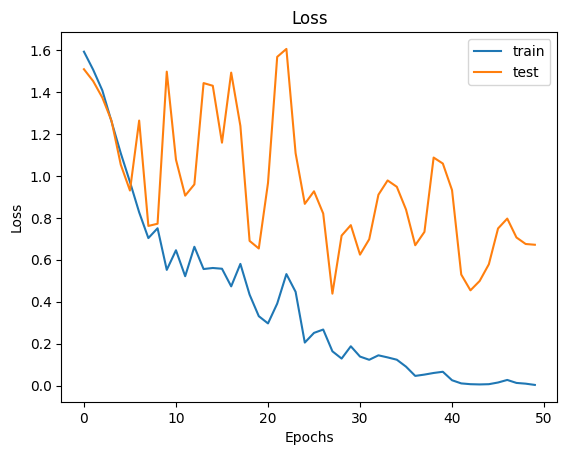

In [53]:
import matplotlib.pyplot as plt
# loss 그래프
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

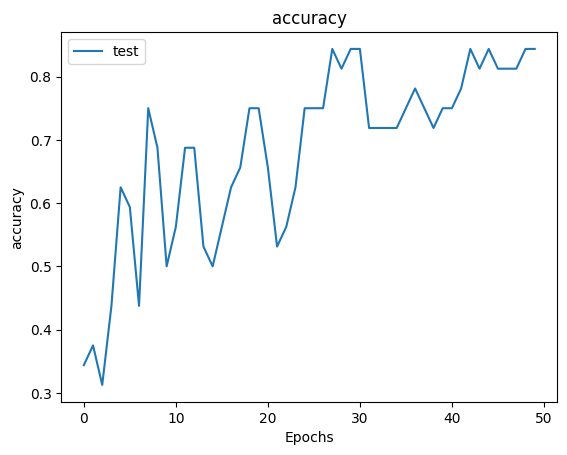

In [ ]:
# accuracy 그래프
plt.plot(accuracy_list, label='test')
plt.title('accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [55]:
from emo_utils import *

def LSTM_predict(model, x_test):
    y_pred = SoftMax(model.forward(x_test, is_training=False))
    return y_pred

y_pred = LSTM_predict(model, test_embeddings)
predicted_classes = np.argmax(y_pred, axis=1)

print("정답(1~26): ",end="")
for i in range(0,len(test_embeddings)//2):
    print(label_to_emoji(test_emoji[i]), end="")
print()
print("예측(1~26): ",end="")
for i in range(0,len(test_embeddings)//2):
    print(label_to_emoji(predicted_classes[i]), end="")
print()
print()
print("정답(27~52): ",end="")
for i in range(len(test_embeddings)//2,len(test_embeddings)):
    print(label_to_emoji(test_emoji[i]), end="")
print()
print("예측(27~52): ",end="")
for i in range(len(test_embeddings)//2,len(test_embeddings)):
    print(label_to_emoji(predicted_classes[i]), end="")


정답(1~26): 🍴😞😄😄😄😄😞😄🍴😄⚾😞😞😞⚾😞😞😄😞🍴❤️😄🍴😞😞😞⚾❤️
예측(1~26): 🍴😞😄❤️😄😄😞❤️🍴😄⚾😞😞😞⚾😞😞😄😞🍴😞❤️🍴😄😞😞⚾❤️

정답(27~52): ⚾😄❤️⚾😞😄😄⚾😄🍴🍴😄⚾❤️❤️⚾😄❤️😄😄😞😞😞❤️😞😄😄🍴
예측(27~52): ⚾😄❤️⚾😄😄😞❤️😄🍴🍴😄⚾❤️❤️⚾😄⚾😄😄😞🍴😞😞😞😄😄🍴